Data extraction and dict construction completed in: 0.03s
loading model from:  ../../../results/riboswitch/mlp_riboswitch_full_best.ckpt
0
Epoch duration =2min 35.14s
Cumulative duration =1.55s

100
Epoch duration =2min 37.92s
Cumulative duration =2min 37.57s

----------------Summing complete----------------
Saving scores to Arrays/riboswitch_mlpriboswitch_full_so1k.npy


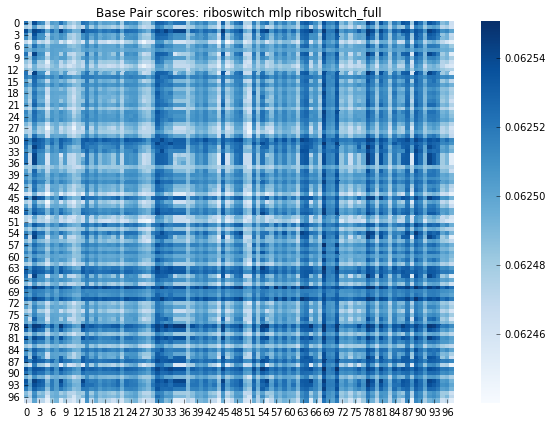

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper 
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE ACTIONS'''
TRAIN = False
TEST = False
WRITE = False
FOM = False
SOMCALC = True
SOMVIS = True

if '--train' in sys.argv:
  TRAIN = True
if '--test' in sys.argv:
  TEST = True
if '--write' in sys.argv:
  WRITE = True
if '--fom' in sys.argv:
  FOM = True
if '--somcalc' in sys.argv:
  SOMCALC = True
if '--somvis' in sys.argv:
  SOMVIS = True

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''

exp = 'riboswitch'  #for the params folder


img_folder = 'Images_mlp'
#---------------------------------------------------------------------------------------------------------------------------------

'''OPEN DATA'''

starttime = time.time()

#Open data from h5py
filename = 'riboswitch_full.hdf5'
with h5py.File(filename, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
train_frac = 0.8
valid_frac = 0.1
test_frac = 1-0.8-valid_frac
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}

print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

simalign_file = 'riboswitch_full.sto'
#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)
#---------------------------------------------------------------------------------------------------------------------------------


'''SAVE PATHS AND PARAMETERS'''
params_results = '../../../results'

modelarch = 'mlp'
trial = 'riboswitch_full'
modelsavename = '%s_%s'%(modelarch, trial)



'''BUILD NEURAL NETWORK'''

def cnn_model(input_shape, output_shape):


  # create model
  layer1 = {'layer': 'input', #41
          'input_shape': input_shape
          }

  layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                      # concat, embedding, variational_normal, variational_softmax, + more
            'num_units': 44,
            'norm': 'batch',          # if removed, automatically adds bias instead
            'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
            'dropout': 0.5,           # if removed, default is no dropout
           }

  layer3 = {'layer': 'dense',
          'num_units': output_shape[1],
          'activation': 'sigmoid'
          }

  model_layers = [layer1, layer2, layer3]

  # optimization parameters
  optimization = {"objective": "binary",
                "optimizer": "adam",
                "learning_rate": 0.0003,
                "l2": 1e-5,
                #"label_smoothing": 0.05,
                #"l1": 1e-6,
                }
  return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = os.path.join(params_results, exp)
param_path = os.path.join(save_path, modelsavename)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)



#---------------------------------------------------------------------------------------------------------------------------------

'''TRAIN '''
if TRAIN:
  # initialize session
  sess = utils.initialize_session()

  #Train the model

  data = {'train': train, 'valid': valid}
  fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=100, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)


  sess.close()

  #---------------------------------------------------------------------------------------------------------------------------------      
'''TEST'''
sess = utils.initialize_session()
if TEST:
  
  # set best parameters
  nntrainer.set_best_parameters(sess)

  # test model
  loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')
  if WRITE:
    metricsline = '%s,%s,%s,%s,%s,%s,%s'%(exp, modelarch, trial, loss, mean_vals[0], mean_vals[1], mean_vals[2])
    fd = open('test_metrics.csv', 'a')
    fd.write(metricsline+'\n')
    fd.close()
'''SORT ACTIVATIONS'''
nntrainer.set_best_parameters(sess)
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

#---------------------------------------------------------------------------------------------------------------------------------
'''FIRST ORDER MUTAGENESIS'''
if FOM:
  plots = 3
  num_plots = range(plots)
  fig = plt.figure(figsize=(15,plots*2+1))
  for ii in num_plots: 

      X = np.expand_dims(test['inputs'][plot_index[10000+ii]], axis=0)
      
      ax = fig.add_subplot(plots, 1, ii+1)
      mf.fom_saliency_mul(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, ax =ax)
      fom_file = modelsavename + 'FoM' + '.png'
  fom_file = os.path.join(img_folder, fom_file)
  plt.savefig(fom_file)

  plt.close()
#---------------------------------------------------------------------------------------------------------------------------------
'''SECOND ORDER MUTAGENESIS'''

'''Som calc'''
if SOMCALC:
  num_summary = 1000

  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  Xdict = test['inputs'][plot_index[:num_summary]]

  mean_mut2 = mf.som_average_ungapped(Xdict, ugidx, arrayspath, nntrainer, sess, progress='short', 
                                             normalize = 'logodds', save=True, layer='dense_1_bias')

if SOMVIS:  
  #Load the saved data
  num_summary = 1000
  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  mean_mut2 = np.load(arrayspath)

  #Reshape into a holistic tensor organizing the mutations into 4*4
  meanhol_mut2 = mean_mut2.reshape(numug,numug,4,4)

  #Normalize
  normalize = True
  if normalize:
      norm_meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, normfactor=1)

  #Let's try something weird
  bpfilter = np.ones((4,4))*0
  for i,j in zip(range(4), range(4)):
      bpfilter[i, -(j+1)] = +1.

  nofilter = np.ones((4,4))

  C = (norm_meanhol_mut2*s)
  C = np.sum((C).reshape(numug,numug,dims*dims), axis=2)
  #C = C - np.mean(C)
  #C = C/np.max(C)

  plt.figure(figsize=(8,6))
  sb.heatmap(C,vmin=None, cmap='Blues', linewidth=0.0)
  plt.title('Base Pair scores: %s %s %s'%(exp, modelarch, trial))

  som_file = modelsavename + 'SoM_bpfilter' + '.png'
  som_file = os.path.join(img_folder, som_file)
  plt.show()
  #plt.savefig(som_file)
  #plt.close()



In [7]:
len(ugSS)

98

In [5]:
simugSS = ':::::(((((,,,,<-<<<<<____>>>>>><<<--<<<<<<______>>>->>>->>>,,,,,)))))-<<<<____>>>>::::::::::::::::'

In [6]:
len(simugSS)

98

In [10]:
SS

':::::(((((,..,,,<-.<<.<<<.........____~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~.........>>>.>.>.><<<-.-<<.<..<<<......______~~~~~~~~~~~~~~~~~~~~~~.....>>>.-..>>>->>>,..........................,,,,.........................)))))..-<<<<...........____~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~................>>>..>::....::::::::::::::'

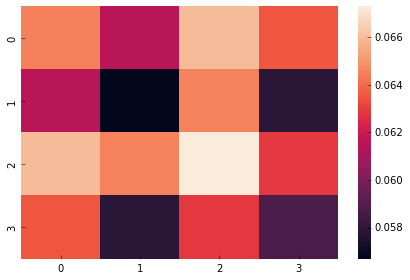

In [14]:
import bpdev as bp

s = bp.avgholbp(ugSS, numbp, dims, norm_meanhol_mut2)
